# 文脈付きバンディット

参考: [Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)

基本的なバンディット問題では何の事前情報も想定していませんが、現実問題では様々な事前情報が得られます。
線形バンディットや文脈付きバンディットでは、アームやバンディット自体に情報がついている状況を想定します。

特に敵対的な文脈付きバンディットでは、次のような流れでアルゴリズムが進んでいきます：

---
1. 敵対者が$\left\{1, \dots, n\right\}$間の報酬を選択します：$(x_t)^n_{t=1}$ with $x_t \in [0, 1]^k$
2. 敵対者が$\left\{1, \dots, n\right\}$間の文脈を選択します：$(c_t)^n_{t=1}$ with $c_t \in C$

続いて、時刻 $t=1, \dots, n$で

1. 学習者が文脈 $c_t \in C$を観測します 
2. 学習者が行動の選択肢としてあり得る分布 $P_t \in \mathcal{P}_{k-1}$を選択し、行動$A_t$を$P_t$からサンプルします。
3. 報酬 $X_t = x_{tA_t}$ を観測します。

---

ここでの「文脈」はRLでの「状態」に相当します。状態の数＞１＆ホライゾン＝１なら文脈付きバンディットと同じです。
このとき、次のようなリグレットが自然に考えられます:

$$R_n = E\left[\sum_{c \in C} \max_{i \in [k]} \sum_{t \in [n]: c_t=c} (x_{ti} - X_t)\right]$$

これはつまり、「文脈に依存した最も良い方策」に対する「実行した方策」のリグレットです。RLでもほぼ同じですね。
* ここで、$x_{ti}$と$X_t$はどちらも「文脈が$c$で条件付けられた時刻$t$」であることに注意してください。そのため、異なる文脈では最適なアームが異なるかもしれません。例えば、$c_1$では最適なアームは$1$でも、$c_4$では$2$かもしれません。
* また、全体での実行ステップ数は$n$であることにも注意してください。$Cn$ではありません。

たとえば文脈が何の情報も持ってない場合を考えてみましょう。そして
$$R_{nc} = E\left[\max_{i \in [k]} \sum_{t \in [n]: c_t=c} (x_{ti} - X_t)\right]$$
を文脈が$c$のときのリグレットとします。EXP3アルゴリズム ([bandit_algorithms.ipynb](bandit_algorithms.ipynb)参照)をそれぞれの文脈で走らせた場合、リグレットの上界は

$$
R_{n c} \leq 2 \sqrt{k \sum_{t=1}^n \mathbb{I}\left\{c_t=c\right\} \log (k)}
$$

になります。よって$R_{n} \leq 2 \sqrt{nk|C|\log (k)}$です。これは文脈の数が非常に大きい場合に全然ダメです。もっと効率よく解けないでしょうか？

現実世界では文脈同士になんの構造もないことはまれです。なんらかの構造の導入がしやすいように、リグレット$R_n$を等価な別の形式で書き換えてみます。

$$
R_n=\mathbb{E}\left[\max _{\phi \in \Phi} \sum_{t=1}^n\left(x_{t \phi\left(c_t\right)}-X_t\right)\right] .
$$

ここで、$\Phi$は$C \to [k]$な関数の集合です。$\Phi = k^C$のとき、これは元の形のリグレットと同じです。$\Phi$のサイズが小さい時は探索空間が小さくなるので、より良いリグレットバウンドが期待できます。
$\Phi$での書き換えを踏まえた上で、文脈付き敵対的バンディットを実装するとこんな感じですね：

```python
X_n = adversary_reward(learner)
assert X_n.shape == (n, k)
C_n = adversary_context(learner)
assert len(C_n) == n

pseudo_regret = 0
for t in range(n):
    c_t = C_n[t]
    P = learner.choose_P(c_t)
    a_t = P.sample()
    X_t = X_n[t, a_t]
    pseudo_regret = X_n[t, optimal_phi(c_t)] - X_t
```

実際に$\Phi$の大きさでリグレットバウンドが改善することを見ていきます。
そのために、一番基本であるエキスパートアドバイス付きバンディットを見てみましょう。

## エキスパートアドバイス付きバンディット

この設定では$M$人の「バンディットを解くエキスパート」を考え、$M$人のなかから一番良いエキスパートを選択することを考えます。
エキスパート$(i) \in [M]$は時刻$t$で文脈$c_t$を受取り、それぞれのアームの引くべき確率を返します。
つまり、敵対者が選択した時刻$t$での文脈はエキスパートの動作に吸収されるので、実装するとこんな感じになります：

```python
X_n = adversary_reward(learner)
assert X_n.shape == (n, k)
E_n = expert_advice(learner)
assert E_n.shape == (n, M, k)

pseudo_regret = 0
for t in range(n):
    P = learner.choose_P()
    e_t = P.sample()
    expert = E_n[t, e_t]  # k
    a_t = expert.sample()
    X_t = X_n[t, a_t]

    best_rew = best_expert @ X_n[t] 
    pseudo_regret = best_rew - X_t
```

### Exp4 アルゴリズム

エキスパートアドバイス付きのアルゴリズムの基本がExp4 (exponential weighting for exploration and exploitation with experts) です。
$\gamma > 0$ のアルゴリズムはExp4-IXと呼ばれます。

時刻$t =1 \dots n$で、
1. エキスパートのアドバイス$E^{(t)}$を取得
2. サンプリング用の分布を計算$P_{t}=Q_t E^{(t)}$
3. アームを選択($A_t \sim P_t$)し、報酬($X_t=x_{tA_t}$)を観測
4. 報酬を推定(これは$\gamma=0$でUnbiasedになってます)
$$\hat{X}_{ti} = 1 - \frac{\mathbb{I}\{A_t=i\}}{P_{ti}+\gamma}(1-X_t)$$
5. 報酬の情報をエキスパートに反映させるやつ
$$\tilde{X}_{t} = E^{t} \hat{X}_t$$
6. エキスパートの分布を更新
$$Q_{t+1, i}=\frac{\exp(\eta\tilde{X}_{ti})Q_{ti}}{\sum^k_{j=1}\exp(\eta\tilde{X}_{tj})Q_{ti}}$$

#### 直感的解釈

アルゴリズムの動作について直感的に説明してみましょう。
例えば$X_t$が$0$に近い値を出したとします。このとき$\hat{X}_{ti}$は小さくなるので、アーム$i$を選択するようなエキスパートの重みは$\tilde{X}_t$によって小さく下げられます。

#### リグレットについて

$\eta = \sqrt{2\log(M)/(nk))}$のときにExp4のリグレットは$R_n \leq 2 \sqrt{nk\log(M)}$で抑えられます。
これがどう文脈付きバンディットに関係するのでしょうか？

$C \to [k]$なる関数$\phi$について、エキスパート$m$が$\phi$に従って動くとします。
つまり、$E^{(t)}_{m}=[\mathbb{I}\{\phi(c_t) = 0\}, \mathbb{I}\{\phi(c_t) = 1\}, \dots, \mathbb{I}\{\phi(c_t) = k\}]$です。$|\Phi|=k^C$ならば$M=k^C$であり、このとき$R_n \leq \sqrt{2nk|C|\log(k)}$ですし、一般には

$$R_n \leq \sqrt{2nk\log(|\Phi|)}$$

になります。つまり、エキスパートとして「あり得る$C \to [k]$の関数全体」を取ってくるとリグレットは全く良くなりませんが、帰納バイアスによってマシな関数を持ってくると、リグレットはだいぶ良くなります。

最後にPythonで実験してみましょう。

<AxesSubplot: xlabel='Step', ylabel='Regret'>

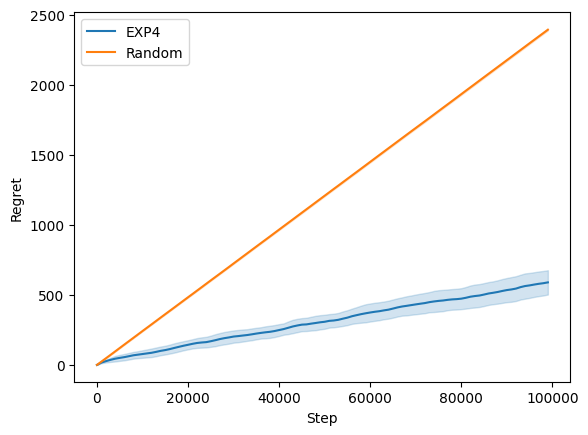

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import special
import seaborn as sns
import pandas as pd

Array = np.ndarray

class UniformBandit:
    def __init__(self, rew_mean: Array):
        self.rew_mean = rew_mean
        self.optimal_mean = np.max(self.rew_mean)

    def pull(self, arm: int):
        mean = self.rew_mean[arm]
        reward = np.random.uniform(0, 1) * 2 * mean
        reward = np.clip(reward, 0, 1)
        return mean, reward


k = 2
C = 30
n_step = 100000
M = 10

def EXP4(lr, seeds=10):
    # コンテキストごとに異なるバンディットを割り当てます
    bandits = [UniformBandit(np.array([0.5, 0.5 + np.random.uniform(-0.1, 0.1)])) for c in range(C)]

    experts = []
    # expert 0はほぼ最適なエキスパートとします
    expert0 = []
    for c in range(C):
        rew_mean = bandits[c].rew_mean
        expert0.append([rew_mean[0] > rew_mean[1], rew_mean[0] <= rew_mean[1]])
        # expert0.append(special.softmax(rew_mean))
    experts.append(expert0)

    # 他のエキスパートはランダムに作ります
    for m in range(M-1):
        experts.append([special.softmax(np.random.randn(2)) for c in range(C)])
    E = np.array(experts)    

    assert E.shape == (M, C, k)

    steps = []
    regrets = []
    random_regrets = []
    for _ in range(seeds):
        Q = np.ones(M) / M
        Q_random = np.ones(M) / M  # 結果の比較用に適当にエキスパートを選ぶやつを作っておきます
        assert Q.shape == (M,)

        pseudo_regret = 0
        random_regret = 0
        regrets.append([])
        random_regrets.append([])
        steps.append([])
        for t in range(n_step):
            # コンテキストが発生
            c_t = np.random.randint(C)
            bandit = bandits[c_t]
            E_t = E[:, c_t, :]

            # エキスパートの選択
            P = (Q.reshape(M, 1) * E_t).sum(axis=0)
            assert P.shape == (k,)
            act = np.random.choice(k, p=P)
            prob = P[act]
            _, rew = bandit.pull(act)
            X_hat = np.ones(k)
            X_hat[act] = 1 - (1 - rew) / prob

            # Qの更新
            X_tilde = np.sum(E_t * X_hat, axis=-1)
            assert X_tilde.shape == (M,)
            assert Q.shape == (M,)
            Q = np.exp(lr * X_tilde) * Q
            Q = Q / Q.sum()

            # 結果の記録
            optimal_expert = E_t[0]
            pseudo_regret += np.sum(optimal_expert * bandit.rew_mean) - np.sum(P * bandit.rew_mean)

            P_random = (Q_random.reshape(M, 1) * E_t).sum(axis=0)
            random_regret += np.sum(optimal_expert * bandit.rew_mean) - np.sum(P_random * bandit.rew_mean)

            if t % 1000 == 0:
                regrets[-1].append(pseudo_regret)
                random_regrets[-1].append(random_regret)
                steps[-1].append(t)
        
    return np.array(steps), np.array(regrets), np.array(random_regrets)

lr = 0.1
steps, regrets, random_regrets = EXP4(lr, seeds=10)
df = pd.DataFrame({"Step": steps.flatten(), "Regret": regrets.flatten()})
random_df = pd.DataFrame({"Step": steps.flatten(), "Regret": random_regrets.flatten()})
sns.lineplot(df, x="Step", y="Regret", errorbar="sd", label="EXP4")
sns.lineplot(random_df, x="Step", y="Regret", errorbar="sd", label="Random")

## 線形バンディット

先程よりも強い仮定を考えてみます。時刻$t$の報酬関数$X_t$が
$$X_t = r(C_t, A_t) + \eta_t$$
のように文脈とアームによる関数で表されるとします。ここで$\eta_t$はノイズであり、$1$-subgaussianとします。

このとき、次のリグレットが考えられます（RLみたいに行動によって文脈が変化する状況は考えません。文脈と行動は独立とします）

$$
R_n = \left[\sum^n_{t=1}\max_{a \in [k]}r(C_t, a) - \sum^n_{t=1}X_t\right]
$$

さらに追加の仮定として、学習者が何らかの特徴マップ$\phi: C \times [k] \to \mathbb{R}^d$にアクセスでき、さらに報酬関数が

$$
r(c, a) = \langle \theta_*, \phi(c, a)\rangle
$$

で表せる状況を仮定します。なんだか難しいことを言ってる気がしますが、直感的には「報酬関数$r$を、特徴ベクトル$\phi$が``とても良く表している``」状況になります。

例えば、2つの文脈アーム $(c_1, a_1)$と $(c_2, a_2)$ を考えます。そして、その2つの特徴ベクトルがよく似ているとします。つまり、$\phi(c_1, a_1) \approx \phi(c_2, a_2)$ です。
このとき、2つの報酬もよく似ていることになります。つまり、$r(c_1, a_1) \approx r(c_2, a_2)$ です。

### 確率的線形バンディット

線形バンディットでは報酬関数が$r(c, a) = \langle \theta_*, \phi(c, a)\rangle$の形をしていることを仮定していました。
つまり、アームによって報酬の内積の中身が確定するので、次のようにシンプルな形で書き直すことができます。

行動の集合として$\mathcal{A}_t \subset \mathbb{R}^d$ を考えて、その中から一つ行動$A_t \in \mathcal{A}_t$ を選択することを考えます。そして、報酬関数を以下で定義します。

$$
X_t = \langle \theta_*, A_t\rangle + \eta_t
$$

ここで$\eta_t$は$1$-subgaussianです。リグレットは以下になります：

$$
\begin{aligned}
\hat{R}_n & =\sum_{t=1}^n \max _{a \in \mathcal{A}_t}\left\langle\theta_*, a-A_t\right\rangle \\
R_n & =\mathbb{E}\left[\hat{R}_n\right]=\mathbb{E}\left[\sum_{t=1}^n \max _{a \in \mathcal{A}_t}\left\langle\theta_*, a\right\rangle-\sum_{t=1}^n X_t\right],
\end{aligned}
$$

これは$\mathcal{A}_t$の構造次第で通常のバンディットも文脈付き線形バンディットも一般化しています。

#### LinUCB

確率的線形バンディットを解くための基本的なアルゴリズムがLinUCBです。通常のUCBではOFUをsub-gaussianにかんする集中不等式で実現していましたが、線形バンディットでは少し複雑になります。
なぜなら報酬はそのアームだけでなく、他のアームの情報も含んでいるためです。
通常のUCBの原理を確認してみます。UCBは次のsub-gaussianの集中不等式に従って各アームの信頼区間を求め、その一番大きい値をスコアとしていました。

$$
P\left(\mu \geq \hat{\mu} + \sqrt{\frac{2 \log(1 / \delta)}{n}}\right) \leq \delta
$$

LinUCBでも似たようなことがしたいわけですね。そこで、LinUCBでは信頼集合$C_t \subset \mathbb{R}^d$を考え、次のUCBスコアを考えます。

$$\mathrm{UCB}_t(a)=\max _{\theta \in \mathcal{C}_t}\langle\theta, a\rangle$$

そして$A_t=\operatorname{argmax}_{a \in \mathcal{A}_t} \operatorname{UCB}_t(a)$でアームを選択します。
$C_t$はどうやって作ればよいでしょうか？UCBの集中不等式を思い返すと、次の性質を満たすべきです。

1. $C_t$は$\theta_*$を高い確率で含む。通常のUCBは$\mu$を$1-\delta$の確率で信頼区間に含んでいました。
2. $C_t$はなるべく小さい方が良い。

また、UCBでは報酬関数を推定していました。このアナロジーとして、LinUCBでは報酬関数のパラメータ$\theta$を学習することを考えます。

$$
\hat{\theta}_t=\operatorname{argmin}_{\theta \in \mathbb{R}^d}\left(\sum_{s=1}^t\left(X_s-\left\langle\theta, A_s\right\rangle\right)^2+\lambda\|\theta\|_2^2\right)
$$

このとき$\hat{\theta}_t=V_t^{-1} \sum_{s=1}^t A_s X_s$ であり、$V_0=\lambda I \quad$ と $\quad V_t=V_0+\sum_{s=1}^t A_s A_s^{\top}$です。そして信頼集合を以下で構築します

$$
\mathcal{C}_t \subseteq \mathcal{E}_t=\left\{\theta \in \mathbb{R}^d:\left\|\theta-\hat{\theta}_{t-1}\right\|_{V_{t-1}}^2 \leq \beta_t\right\}
$$

このような信頼集合では、
* $1 \geq \beta_1 \geq \beta_2 \geq \dots \geq \beta_n$
* $\max_{t\in [n]}\sup_{a, b\in \mathcal{A}_t}\langle \theta_*, a-b\rangle \leq 1$
* $\|a\|_2\leq L$ が任意の $a \in \cup^n_{t=1}\mathcal{A}_t$で成立
* $\theta_* \in C_t$が確率$1-\delta$以上で成立

するとき、LinUCBのリグレットバウンドが

$$
\hat{R}_n \leq \sqrt{8n\beta_n \log\left(\frac{\det V_n}{\det V_0}\right)}
\leq \sqrt{8dn\beta_n \log\left(\frac{d \lambda + nL^2}{d\lambda}\right)}
$$

になることが証明できます。

TODO: 証明を書く


早速PythonでLinUCBを試してみますが、実装の際に注意点があります。
LinUCBでは成約付き最適化問題を解く必要がありますが、これは一般に効率よく解けるか微妙です。
今回は簡単のためにアームの数が有限であり、

$$
A_t = \text{argmax}_{a \in \mathcal{A}_t} \langle \hat \theta_{t-1}, a \rangle + \sqrt{\beta_t} \|a\|_{V^{-1}_{t-1}}
$$
をアーム全て調べて選択します。

また、$\beta_t = \sqrt{\lambda}m_2 + \sqrt{2\log\left(\frac{1}{\delta}\right) + d \log\left(\frac{d\lambda + tL^2}{d\lambda}\right)}$とすると理論的に良いことが知られています。 ここで$m_2$は$\|\theta_*\|_2$の上界です。


Bandit AlgorithmsのFigure 19.1を再現してみましょう。

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_4886/3416719394.py:21: RuntimeWarning: divide by zero encountered in divide
  ucb = np.where(num_arm_pulled == 0, np.infty, avg_rewards + np.sqrt(2 * np.log(n_step**2) / num_arm_pulled))
100%|██████████| 10/10 [00:49<00:00,  4.97s/it]


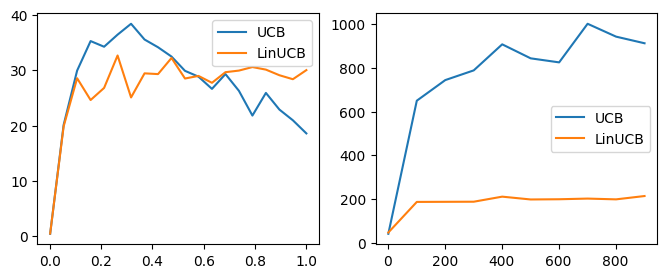

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
Array = np.ndarray


def upper_confidence_bound(bandit, n_step, seeds=100):
    # 通常のUCBアルゴリズムです
    regrets = []
    k = len(bandit.arms)
    for _ in range(seeds):
        bandit.reset()
        avg_rewards = np.zeros(k)
        num_arm_pulled = np.zeros(k)

        pseudo_regret = 0
        for i in range(n_step):
            # UCBスコアの計算と行動選択
            ucb = np.where(num_arm_pulled == 0, np.infty, avg_rewards + np.sqrt(2 * np.log(n_step**2) / num_arm_pulled))
            act = np.argmax(ucb)
            mean, rew = bandit.pull(act)

            # 平均値と探索結果の記録
            num_pulled = num_arm_pulled[act]
            avg_rewards[act] += (rew - avg_rewards[act]) / (num_pulled + 1)
            num_arm_pulled[act] += 1

            # 結果の記録
            pseudo_regret += bandit.optimal_mean - mean
    
        regrets.append(pseudo_regret)
    return np.mean(regrets)


def lin_ucb(bandit, n_step, lam=0.1, seeds=100):
    # 線形UCBアルゴリズムです
    regrets = []
    k = len(bandit.arms)
    d = bandit.feature_dim
    for _ in range(seeds):
        bandit.reset()
        arms = bandit.arms  # k x d
        Vt = lam * np.eye(d)
        theta_hat = np.zeros(d)
        AX = np.zeros((d, 1))
        pseudo_regret = 0
        for i in range(n_step):
            # UCBスコアの計算
            delta = 0.01
            sqrt_beta_t = np.sqrt(lam) + np.sqrt(2 * np.log(1 / delta) + d * np.log((d * lam + (i+1)) / (d * lam)))
            beta_t = sqrt_beta_t ** 2
            theta_a = arms @ theta_hat  # k
            Vt_inv = np.linalg.inv(Vt)
            beta_a_norm = beta_t * np.array([arm @ Vt_inv @ arm for arm in arms])
            ucb = theta_a + beta_a_norm

            # UCBスコアが最大のアームを選択
            arm = np.argmax(ucb)
            mean, rew = bandit.pull(arm)

            # 結果の記録
            pseudo_regret += bandit.optimal_mean - mean
            arm = arms[arm].reshape(d, 1)
            Vt += arm @ arm.T
            AX += arm * rew
            theta_hat = (np.linalg.inv(Vt) @ AX).reshape(-1)
            assert Vt.shape == (d, d)
            assert AX.shape == (d, 1)
    
        regrets.append(pseudo_regret)
    return np.mean(regrets)


plt.figure(figsize=(8, 3))

# 2アームガウシアンバンディットでUCBとLinUCBを比較します

class GaussianBandit:
    def __init__(self, rew_mean: Array, noise_scale: float):
        self.rew_mean = rew_mean
        self.noise_scale = noise_scale
        self.optimal_mean = np.max(self.rew_mean)
        self.arms = np.eye(len(rew_mean))  # アーム同士は文脈を共有しません
        self.feature_dim = self.arms.shape[1]

    def reset(self):
        pass

    def pull(self, arm):
        A = self.arms[arm]
        mean = np.sum(self.rew_mean * A)  # 内積を取ります
        noise = np.random.randn() * self.noise_scale
        reward = mean + noise
        return mean, reward


n_step = 1000
gaps = np.linspace(0.001, 1.0, 20)
ucb_regrets = []
linucb_regrets = []
for gap in tqdm(gaps):
    bandit = GaussianBandit(np.array([0.0, -gap]), 1.0)
    ucb_regrets.append(upper_confidence_bound(bandit, n_step, seeds=30))
    linucb_regrets.append(lin_ucb(bandit, n_step, seeds=30))


plt.subplot(1, 2, 1)
plt.plot(gaps, ucb_regrets, label="UCB")
plt.plot(gaps, linucb_regrets, label="LinUCB")
plt.legend()


# 線形バンディットでUCBとLinUCBを比較します

class StochasticLinearBandit:
    def __init__(self, k: int, d: int, noise_scale: float):
        self.k = k
        self.d = d
        self.noise_scale = noise_scale
        self.theta_star = np.random.uniform(0, 1, size=(d,))
        self.arms = np.random.uniform(0, 1, size=(k, d))
        self.optimal_mean = np.max(self.arms @ self.theta_star)
        self.feature_dim = self.arms.shape[1]

    def reset(self):
        self.theta_star = np.random.uniform(0, 1, size=(self.d,))
        self.arms = np.random.uniform(0, 1, size=(self.k, self.d))
        self.optimal_mean = np.max(self.arms @ self.theta_star)

    def pull(self, arm):
        A = self.arms[arm]
        assert A.shape == (d,)
        assert self.theta_star.shape == (d,)
        mean = self.theta_star @ A
        noise = np.random.randn() * self.noise_scale
        reward = mean + noise
        return mean, reward


n_step = 1000
d = 5
ucb_regrets = []
linucb_regrets = []
num_arms = []
for k in tqdm(range(2, 1000, 100)):
    num_arms.append(k)
    bandit = StochasticLinearBandit(k, d, 1.0)
    ucb_regrets.append(upper_confidence_bound(bandit, n_step, seeds=10))
    linucb_regrets.append(lin_ucb(bandit, n_step, seeds=10))


plt.subplot(1, 2, 2)
plt.plot(num_arms, ucb_regrets, label="UCB")
plt.plot(num_arms, linucb_regrets, label="LinUCB")
plt.legend()
